# Homework 8 - Campaign Response Model
**Subject:** BADS 7105 - CRM Analytics and Intelligence  
**Student:** Pawarut Kongratana (6210422006)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [7]:
df_r = pd.read_csv('Retail_Data_Response.csv')
df_t = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])
df_r.head(3)

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1


In [8]:
df_t.head(3)

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52


In [11]:
oldest = df_t['trans_date'].max()
print(oldest)

2015-03-16 00:00:00


# Data Prep

In [12]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_t['recent']= campaign_date - df_t['trans_date']
df_t['recent'].astype('timedelta64[D]')
df_t['recent']=df_t['recent'] / np.timedelta64(1, 'D')
df_t.head(3)

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0


In [14]:
## create data set with RFM variables

df_rfm = df_t.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)
df_rfm = df_rfm.reset_index()
df_rfm.head(3)

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432


# Responding rate

In [15]:
response_rate = df_r.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head(3)

,response,customer_id
0,0,6237
1,1,647


In [17]:
df_model = pd.merge(df_r,df_rfm)
df_model.head(3)

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432


Text(0.5, 1.05, 'Pearson correlation of Features')

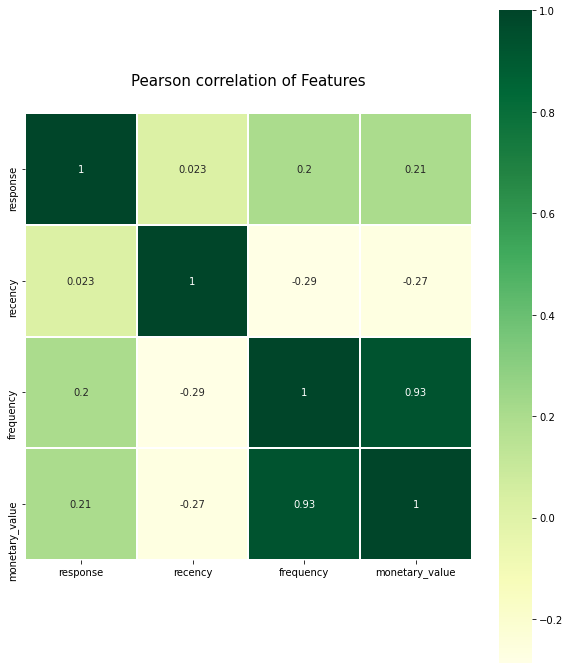

In [18]:
%matplotlib inline
corr = df_model.corr()

f, ax = plt.subplots(figsize=(10, 12))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

c:\users\pawarutk\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\pawarutk\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\pawarutk\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to us

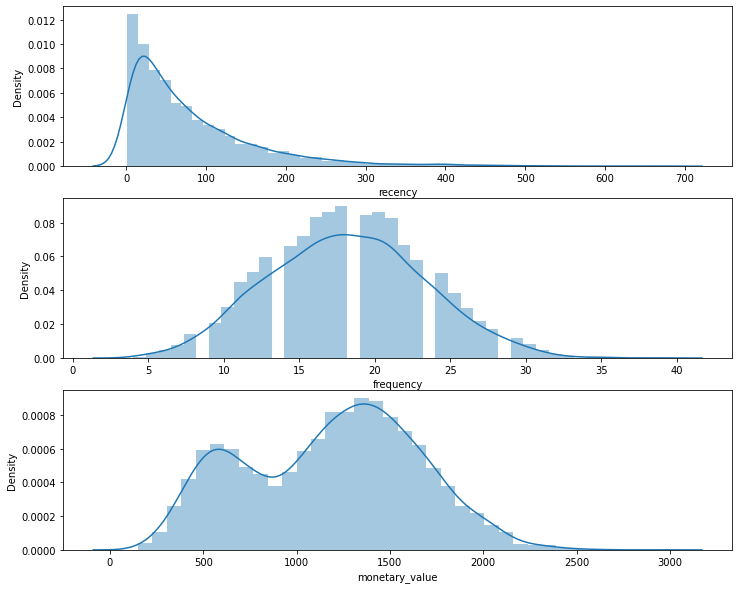

In [19]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_model['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_model['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_model['monetary_value'])
# Show the plot
plt.show()

In [21]:
# Calculate R, F, and M
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(df_model['recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(df_model['frequency'], q=4, labels=f_labels)
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(df_model['monetary_value'], q=4, labels=m_labels)

df_model = df_model.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)
df_model.head(3)


,customer_id,response,recency,frequency,monetary_value,R,F,M
0,CS1112,0,62.0,15,1012,2,2,2
1,CS1113,0,36.0,20,1490,3,3,3
2,CS1114,1,33.0,19,1432,3,3,3


In [22]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
df_model['RFM_Segment_Concat'] = df_model.apply(join_rfm, axis=1)
rfm = df_model
rfm.head(3)

,customer_id,response,recency,frequency,monetary_value,R,F,M,RFM_Segment_Concat
0,CS1112,0,62.0,15,1012,2,2,2,222
1,CS1113,0,36.0,20,1490,3,3,3,333
2,CS1114,1,33.0,19,1432,3,3,3,333


In [29]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print("Unique Segments :",rfm_count_unique.sum())

# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print("RFM Score\n",rfm['RFM_Score'].head())

Unique Segments : 48
RFM Score
 0     6
1     9
2     9
3    11
4     4
Name: RFM_Score, dtype: int64


In [31]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head(3)

,customer_id,response,recency,frequency,monetary_value,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,CS1112,0,62.0,15,1012,2,2,2,222,6,Potential
1,CS1113,0,36.0,20,1490,3,3,3,333,9,Can't Loose Them
2,CS1114,1,33.0,19,1432,3,3,3,333,9,Can't Loose Them


In [32]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   recency frequency monetary_value      
                      mean      mean           mean count
RFM_Level                                                
Can't Loose Them      41.3      23.2         1625.4  2533
Champions             57.1      18.8         1264.1   844
Loyal                 81.0      17.5         1136.0   850
Needs Attention      131.4      12.7          649.5   548
Potential             70.0      15.0          893.7   827
Promising            109.2      14.1          818.9   737
Require Activation   231.0      10.8          502.9   545


In [33]:
df_model.head()

,customer_id,response,recency,frequency,monetary_value,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
0,CS1112,0,62.0,15,1012,2,2,2,222,6,Potential
1,CS1113,0,36.0,20,1490,3,3,3,333,9,Can't Loose Them
2,CS1114,1,33.0,19,1432,3,3,3,333,9,Can't Loose Them
3,CS1115,1,12.0,22,1659,4,3,4,434,11,Can't Loose Them
4,CS1116,1,204.0,13,857,1,1,2,112,4,Needs Attention


# Train & Test Data

In [91]:
## spliting dataframe into X and y
df_l1= df_model[df_model['RFM_Level']=="Require Activation"]
##dfpontential.head()
X = df_l1.drop(columns=['response','customer_id','frequency','R','F','M','RFM_Segment_Concat','RFM_Score','RFM_Level'])
y = df_l1['response']
X.head(3)

,recency,monetary_value
112,116.0,578
127,253.0,771
409,195.0,671


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (381, 2)
Number transactions y_train dataset:  (381,)
Number transactions X_test dataset:  (164, 2)
Number transactions y_test dataset:  (164,)


Text(0.5, 1.0, 'Imbalanced Data')

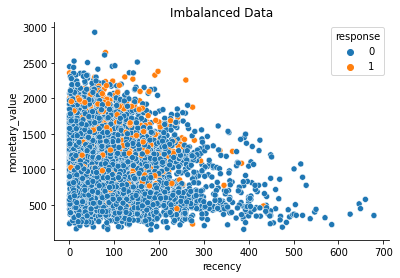

In [93]:
sns.scatterplot(data=df_model, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

# Fixing imbalanced with SMOTE

Text(0.5, 1.0, 'SMOTE Data')

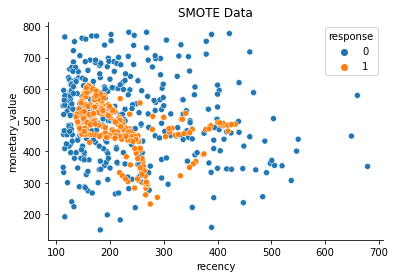

In [94]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'monetary_value', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

In [95]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.65      0.49      0.56       372
           1       0.59      0.73      0.65       372

    accuracy                           0.61       744
   macro avg       0.62      0.61      0.61       744
weighted avg       0.62      0.61      0.61       744

test set
              precision    recall  f1-score   support

           0       0.99      0.44      0.61       161
           1       0.02      0.67      0.04         3

    accuracy                           0.45       164
   macro avg       0.50      0.55      0.33       164
weighted avg       0.97      0.45      0.60       164



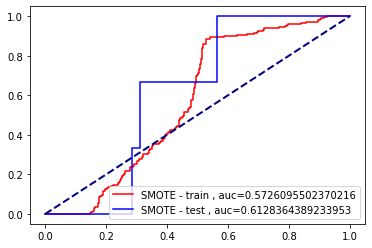

In [96]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()